Calculating Momentum per Quarter...
Simulating Strategy (1 Unit Constraint)...
 PERFORMANCE REPORT (Daily Aggregation) - 1 Unit Fixed Strategy


/var/folders/3h/3r1g6ccn01v_37rgl_0q98rw0000gn/T/ipykernel_10202/1714996352.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)


,Quarter,Gross SR,Net SR,Gross CR,Net CR,Gross CumP&L,Net CumP&L,Av. Trades
0,2023_Q1,3.68,3.66,13.75,13.67,"$12,809","$12,734",0.1
1,2023_Q3,-6.00,-6.03,-3.68,-3.68,"$-20,570","$-20,720",0.2
2,2023_Q4,0.16,0.10,0.28,0.16,"$1,003",$603,0.6
3,2024_Q2,1.05,1.02,2.25,2.15,"$8,570","$8,270",0.4
4,2024_Q4,1.21,1.17,4.31,4.07,"$12,738","$12,338",0.6
5,2025_Q1,-2.50,-2.59,-2.88,-2.93,"$-16,098","$-16,648",0.8
6,2025_Q2,-1.91,-1.93,-4.74,-4.75,"$-24,898","$-25,298",0.6


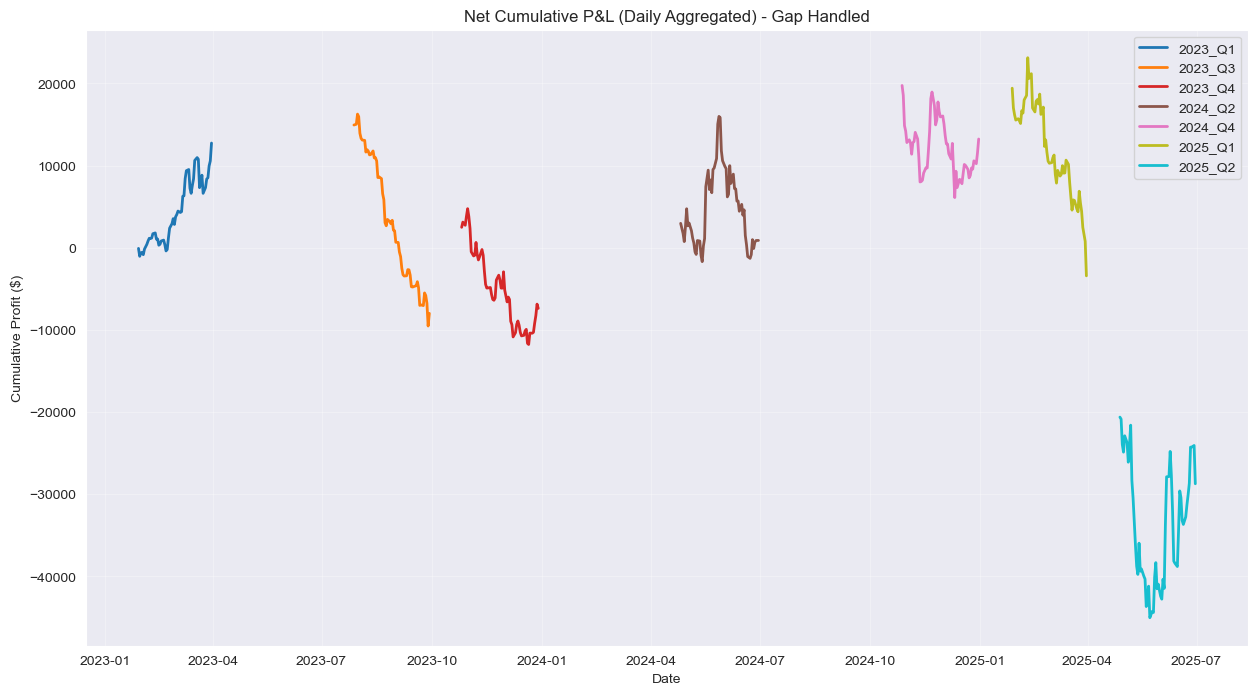

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # Strategy Parameters
    MOMENTUM_WINDOW = 276 * 20
    REBALANCE_FREQ = 276
    ANNUALIZATION = 252

# ==========================================
# 2. Data Preparation
# ==========================================
def prepare_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    print("Calculating Momentum per Quarter...")

    def calc_mom(group):
        if len(group) < cfg.MOMENTUM_WINDOW:
            group['XAU_Mom'] = np.nan
            group['XAG_Mom'] = np.nan
        else:
            group['XAU_Mom'] = np.log(group['XAU'] / group['XAU'].shift(cfg.MOMENTUM_WINDOW))
            group['XAG_Mom'] = np.log(group['XAG'] / group['XAG'].shift(cfg.MOMENTUM_WINDOW))
        return group

    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)
    data.dropna(subset=['XAU_Mom', 'XAG_Mom'], inplace=True)

    return data

# ==========================================
# 3. Strategy Logic
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    dates = data.index
    mom_xau = data['XAU_Mom'].values
    mom_xag = data['XAG_Mom'].values
    in_sample = data['Is_In_Sample'].values

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)

    curr_pos_xau = 0
    curr_pos_xag = 0

    print("Simulating Strategy (1 Unit Constraint)...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        if i % cfg.REBALANCE_FREQ == 0:
            m_xau = mom_xau[i]
            m_xag = mom_xag[i]

            if m_xau > m_xag:
                curr_pos_xau = 1
                curr_pos_xag = -1
            else:
                curr_pos_xau = -1
                curr_pos_xag = 1

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0)

    return data

# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()

    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'] + df['Gross_PnL_XAG']

    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + \
                       (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats

# ==========================================
# 5. Performance Stats (Per Quarter) - FIX APPLIED
# ==========================================
def generate_quarterly_report(daily_df, cfg):
    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    print(f"{'='*80}")
    print(f" PERFORMANCE REPORT (Daily Aggregation) - 1 Unit Fixed Strategy")
    print(f"{'='*80}")

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        # Cum P&L
        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio
        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        # Calmar Ratio
        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        annualized_pnl_g = gross_cum_pnl / years if years > 0 else 0
        gross_cr = (annualized_pnl_g / max_dd_g) if max_dd_g > 0 else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        annualized_pnl_n = net_cum_pnl / years if years > 0 else 0
        net_cr = (annualized_pnl_n / max_dd_n) if max_dd_n > 0 else 0

        # Trades
        av_ntrades = d_q['Total_Trades'].mean()

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Av. Trades': av_ntrades
        })

    stats_df = pd.DataFrame(stats_list)

    format_dict = {
        'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
        'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
        'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
        'Av. Trades': '{:.1f}'
    }

    display(stats_df.style.format(format_dict).background_gradient(subset=['Net CumP&L'], cmap='RdYlGn'))

    # 【修正箇所】daily_stats ではなく引数の daily_df を返す
    return stats_df, daily_df

# ==========================================
# 6. Visualization
# ==========================================
def plot_quarterly_equity(daily_stats):
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Net Cumulative P&L (Daily Aggregated) - Gap Handled')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# ==========================================
# 7. Execution
# ==========================================
cfg = Config()
df_prep = prepare_data(cfg.FILE_PATH, cfg)

if df_prep is not None:
    # Run Strategy
    df_res = run_strategy(df_prep, cfg)

    # Calculate Daily Metrics
    daily_data = calculate_metrics(df_res, cfg)

    # Generate Report
    stats_table, daily_with_equity = generate_quarterly_report(daily_data, cfg)

    # Plot
    plot_quarterly_equity(daily_with_equity)